<h2>Indexing the document collection</h2>

<h3>Settings & utilities</h3>

In [30]:
#imports
import xml.etree.ElementTree as ET
import os
import string
import numpy as np
from matplotlib import pyplot as plt
import math
import re    #RegEx
import spacy #lemmatization
from collections import OrderedDict
import pickle #serialize object read/write files
import time
from mpl_toolkits.mplot3d import Axes3D

#Local import
%run "contraction.py"

#config
%config InlineBackend.figure_format = 'retina'

<h3>Utilities</h3>


In [31]:
def divideList(list_in, percentage, seed):
    if percentage < 0 or percentage > 1:
        print('Percentage must be between 0 and 1')
        return []
    np.random.seed(seed)
    idx = np.random.shuffle(list_in)
    if percentage == 1:
        return list_in
    i = round(len(list_in) * percentage)
    return list_in[0:i]

#divideList([0,1,2,3,4,5,6,7,8,9], 0.7, 1)

<h3>Load stopwords</h2>

In [32]:
#Load a stopword list NLTK
gist_file = open("stopwords.txt", "r")
try:
    content = gist_file.read()
    stopwords = content.split(",")
finally:
    gist_file.close()

<h3>Load document collection</h3>

In [33]:
#path to the document collection
collection_path = 'C:/Users/Stefano Marzo/Documents/DCU Master Dublin/05 Second semester modules/CA6005 Mechanics of search/01 Assignment/COLLECTION'

def getDocumentList(path):
    return os.listdir(path)
    
#generate document name list
doc_list = getDocumentList(collection_path)

<h3>Load queries</h3>

In [34]:
queries_path = 'C:/Users/Stefano Marzo/Documents/DCU Master Dublin/05 Second semester modules/CA6005 Mechanics of search/01 Assignment/topics'

#generate query name list
queries_list = getDocumentList(queries_path)

<h3>Experiments:</h3>
<h4>Vector space model</h4>
<p>Three cases:</p>
<ul>
    <li>Case 0: Documents are indexed on HEADLINE</li>
    <li>Case 1: Documents are indexed on TEXT</li>
    <li>Case 2: Documents are indexed on concatenation of HEADLINE and TEXT</li>
</ul>

<h3>Classes for handle XML documents and the Document Collection</h3>

In [35]:
#relevant document tags 
DOCID = 'DOCID'
HEADLINE = 'HEADLINE'
TEXT = 'TEXT'

class XmlDoc:
    def __init__(self, xml):
        tree = ET.parse(xml)
        root = tree.getroot()
        for id in root.iter(DOCID):
            self.id = id.text if id.text is not None else ''
        for h in root.iter(HEADLINE):
            self.headline = h.text if h.text is not None else ''
        for t in root.iter(TEXT):
            self.text = t.text if t.text is not None else ''
        
        #VSM
        #self.processedText = processText(self.headline)                   #case: 0
        #self.processedText = processText(self.text)                       #case: 1
        #self.processedText = processText(self.text + ' ' + self.headline) #case: 2
        
        #BM25
        #self.processedText = processText(self.text + ' ' + self.headline) #case: 3
        
        #BM25F
        self.processedHeadline = processText(self.headline)               #case: 4
        self.processedBody = processText(self.text)                       #case: 4
        self.processedText = self.processedBody + self.processedHeadline  #case: 4
        #LM
        
        self.tfIndex = self.__getTF__()
        self.tfHeadIndex = self.__getTFHeadline__()
        self.tfBodyIndex = self.__getTFBody__()
    
    def getId(self):
        return self.id
    
    def __getTFHeadline__(self):
        num_terms = len(self.processedHeadline)
        tfIndex = {}
        for term in self.processedHeadline:
            if term not in tfIndex: #save some time
                tfIndex[term] = self.processedHeadline.count(term)/num_terms 
        return tfIndex
    
    def __getTFBody__(self):
        num_terms = len(self.processedBody)
        tfIndex = {}
        for term in self.processedBody:
            if term not in tfIndex: #save some time
                tfIndex[term] = self.processedBody.count(term)/num_terms 
        return tfIndex
    
    def __getTF__(self):
        #tf is on processedText
        #tf has 2 possible implementations
        #1. f/max_occurance of most frequent term
        #2. f/number_different_terms or number_total_terms?
        num_terms = len(self.processedText)
        tfIndex = {}
        for term in self.processedText:
            if term not in tfIndex: #save some time
                tfIndex[term] = self.processedText.count(term)/num_terms
        return tfIndex

class DocumentCollection:
    def __init__(self, path, doc_list, fileName='document-collection.dictionary'):
        self.__name__ = 'Document Collection'
        
        #List of XmlDoc object
        self.docs = {}
        for d in doc_list:
            xmlDocument = XmlDoc(path + '/' + d)
            self.docs[xmlDocument.id] = xmlDocument
        
        #Inverted index
        self.inverted_index = {}
        for id in self.docs.keys():
            for term in self.docs[id].processedText:
                if term in self.inverted_index:
                    self.inverted_index[term].add(id)
                else: self.inverted_index[term] = {id}
        
        #Table of IDF
        self.idf = {}
        for term in self.inverted_index.keys():
            self.idf[term] = np.log(len(self.docs) / len(self.inverted_index[term]))
            
        #Average document length
        self.avgdl = np.mean([len(item.processedText) for k, item in self.docs.items()])
        
        with open(fileName, 'wb') as dictionary_file:
            pickle.dump(self, dictionary_file)
            
    
    def getRelevance(self, documentID, term):
        try:
            return self.docs[documentID].tfIndex[term] * self.idf[term]
        except: 
            return 0
        
    def getWeightedTf(self, docId, term, w_head=1, w_body=1):
        try:
            tfBody = self.docs[docId].tfBodyIndex[term] * w_body
        except:
            tfBody = 0
        try:
            tfHead = self.docs[docId].tfHeadIndex[term] * w_head
        except:
            tfHead = 0
        try:
            return (tfBody + tfHead)
        except:
            return 0


In [62]:
document_collection.getRelevance('LA062294-0251', 'lot')

0.008191890277295659

<h3>Classes for handle XML queries and the Query Collection</h3>

In [36]:
#relevant document tags 
QUERYID = 'QUERYID'
TITLE = 'TITLE'
DESC = 'DESC'

class XmlQuery:
    def __init__(self, xml):
        tree = ET.parse(xml)
        root = tree.getroot()
        for id in root.iter(QUERYID):
            self.id = id.text
        for h in root.iter(TITLE):
            self.title = h.text
        for t in root.iter(DESC):
            self.desc = t.text 
        self.processedText = processText(self.title)
        self.tfIndex = self.__getTF__()
        
    def __getTF__(self):
        #tf is on text, not headline
        #tf has 2 possible implementations
        #1. f/max_occurance of most frequent term
        #2. f/number_different_terms or number_total_terms?
        num_terms = len(self.processedText)
        tfIndex = {}
        for term in self.processedText:
            if term not in tfIndex: #save some time
                tfIndex[term] = self.processedText.count(term)/num_terms
        return tfIndex

class QueryCollection:
    def __init__(self, path, query_list, fileName='query-collection.dictionary'):
        #List of XmlDoc object
        self.queries = {}
        for d in query_list:
            xmlQuery = XmlQuery(path + '/' + d)
            self.queries[xmlQuery.id] = xmlQuery
        
        #Inverted index
        self.inverted_index = {}
        for id in self.queries.keys():
            for term in self.queries[id].processedText:
                if term in self.inverted_index:
                    self.inverted_index[term].add(id)
                else: self.inverted_index[term] = {id}
        
        #Table of IDF
        self.idf = {}
        for term in self.inverted_index.keys():
            self.idf[term] = np.log(len(self.queries) / len(self.inverted_index[term]))
        
        with open(fileName, 'wb') as dictionary_file:
            pickle.dump(self, dictionary_file)
            
    
    def getRelevance(self, queryID, term):
        try:
            return self.queries[queryID].tfIndex[term] * self.idf[term]
        except: 
            return 0
    
    
            
#xmlq = XmlQuery(queries_path + '/' + queries_list[0])
#xmlq.title

<h2>Processing text</h2>

In [37]:
#Process text to meet the IR requirements
use_lemmatization = False

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Lemmatization
# https://www.analyticsvidhya.com/blog/2019/08
#/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python
#/?utm_source=blog&utm_medium=information-retrieval-using-word2vec-based-vector-space-model
nlp = spacy.load('en_core_web_sm',disable=['ner','parser'])
nlp.max_length=5000000

def lemmatize(x):
    if use_lemmatization:
        return ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)])
    else:
        return x
    
#Returns a list of relevant terms
def processText(text):
    #remove punctuation and stopwords
    #remove single punctuation characters, remove points (not separated from string), lower case all 
    if not isinstance(text, str) :
        return []
    #lower the text
    text = text.lower()
    #expand contractions
    text = expand_contractions(text)
    #lemmatize
    text = lemmatize(text)
    return list(filter(lambda el: el not in string.punctuation 
                       and el not in stopwords, 
                       text.translate(str.maketrans('', '', '.')).split()))

#processText('asked processed figuring the foundation')
#processText("O'reilly's")
#processText("I'm Stefano")

<h2>Create Document Collection and Query Collection objects</h2>

In [38]:
recomputeAll = True
#seed for random number
seed = 1

#divide the document collection (get pd% of documents)
pd = 1
doc_list = divideList(doc_list, pd, seed)

#divide the query collection (get pq% of documents)
pq = 1
queries_list = divideList(queries_list, pq, seed)

#Compute or read document collection
computeDocumentCollection = False or recomputeAll
documentCollectionFileName = 'document-collection.dictionary'

#create a Document collection object
if computeDocumentCollection or not os.path.isfile(documentCollectionFileName):
    start = time.time()
    document_collection = DocumentCollection(collection_path, doc_list, documentCollectionFileName)
    end = time.time()
    print('Document Collection Computed in ' + str(round(end - start, 4)) + 's')
else:
    start = time.time()
    with open(documentCollectionFileName, 'rb') as dictionary_file:
        document_collection = pickle.load(dictionary_file) 
    end = time.time()
    print('Document Collection Loaded in ' + str(round(end - start, 4)) + 's')

#Compute or read query collection
computeQueryCollection = False or recomputeAll
queryCollectionFileName = 'query-collection.dictionary'

#create a Query collection object
if computeQueryCollection or not os.path.isfile(queryCollectionFileName):
    start = time.time()
    query_collection = QueryCollection(queries_path, queries_list, queryCollectionFileName)
    end = time.time()
    print('Query Collection Computed in ' + str(round(end - start, 4)) + 's')
else:
    start = time.time()
    with open(queryCollectionFileName, 'rb') as dictionary_file:
        query_collection = pickle.load(dictionary_file) 
    end = time.time()
    print('Query Collection Loaded in ' + str(round(end - start, 4)) + 's')

#pointer to inverted index
inverted_index = document_collection.inverted_index

Document Collection Computed in 300.8931s
Query Collection Computed in 0.0534s


<h2>Heaps' law</h2>
<h2>$M = kT^b$</h2>
<p>where:</p>
<ul>
    <li>$M$ is the document length </li>
    <li>$T$ is the number of distinct terms, i.e. <i>Token</i> </li>
    <li>$k$ is a parameter s.t. $10 \leq k \leq 100$ </li>
    <li>$b$ is a parameter s.t. $0.4 \leq b \leq 0.6$ </li>
</ul>

In [39]:
k = 22
b = .6

#heap function
def heaps(k,T,b):
    return np.power(T, b) * k

In [40]:
#documents data (limit to L documents)
L = 20 #500 #for final result
word_list = []
unique_words = []
for doc in list(document_collection.docs.keys())[0:L]:
    word_list += document_collection.docs[doc].processedText

for i, w in enumerate(word_list):
    unique_words += [len(set(word_list[0:i]))]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


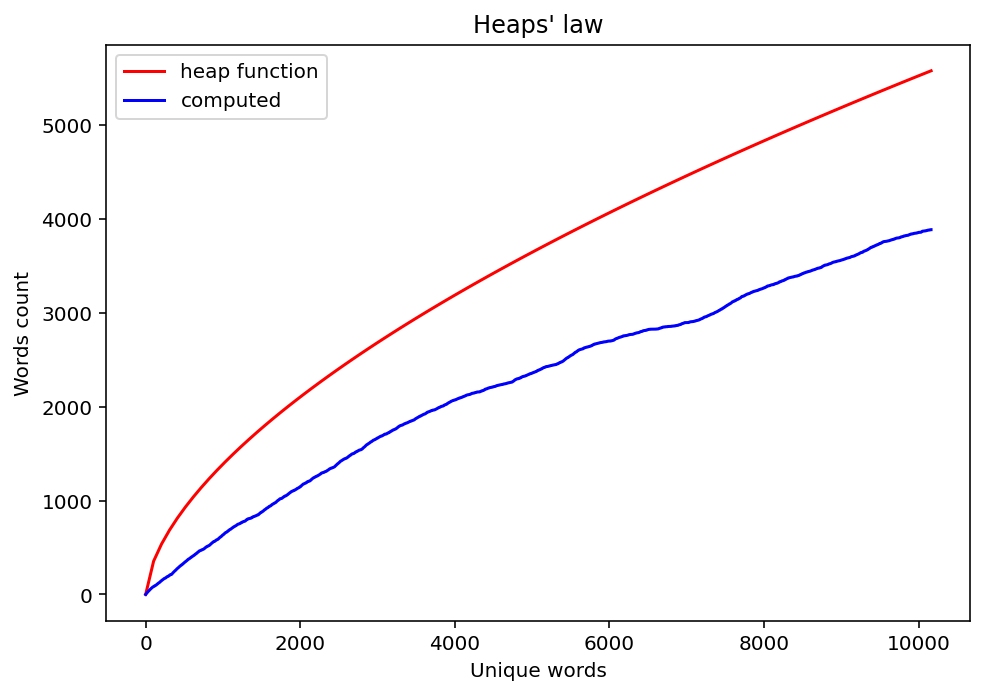

In [12]:
#plot
x = np.linspace(0, len(word_list), 100)

fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
plt.plot(x, heaps(k, x, b), color='red', label='heap function')
plt.plot(np.arange(len(unique_words)), unique_words, color='blue', label='computed')
ax.set_xlabel('Unique words')
ax.set_ylabel('Words count')
ax.set_title('Heaps\' law')
plt.legend()
fig.savefig('Report/imgs/heaps.eps', format='eps', bbox_inches='tight')
plt.show()

<h2>Zipf's law</h2>
<h2>$f = \frac{k}{r}$</h2>
<p>where:</p>
<ul>
    <li>$f$ is the word frequency</li>
    <li>$k$ is a parameter that change with the language (0.1 for english)</li>
    <li>$r$ is the <i>rank</i> of the word</li>
</ul>

In [13]:
#Zipf's formula
kz = 1
frequencies = []
ranks = []
tot_words = len(inverted_index)
for word in inverted_index.keys():
    frequencies += [len(inverted_index[word])]
    ranks += [np.log(kz/frequencies[-1])]

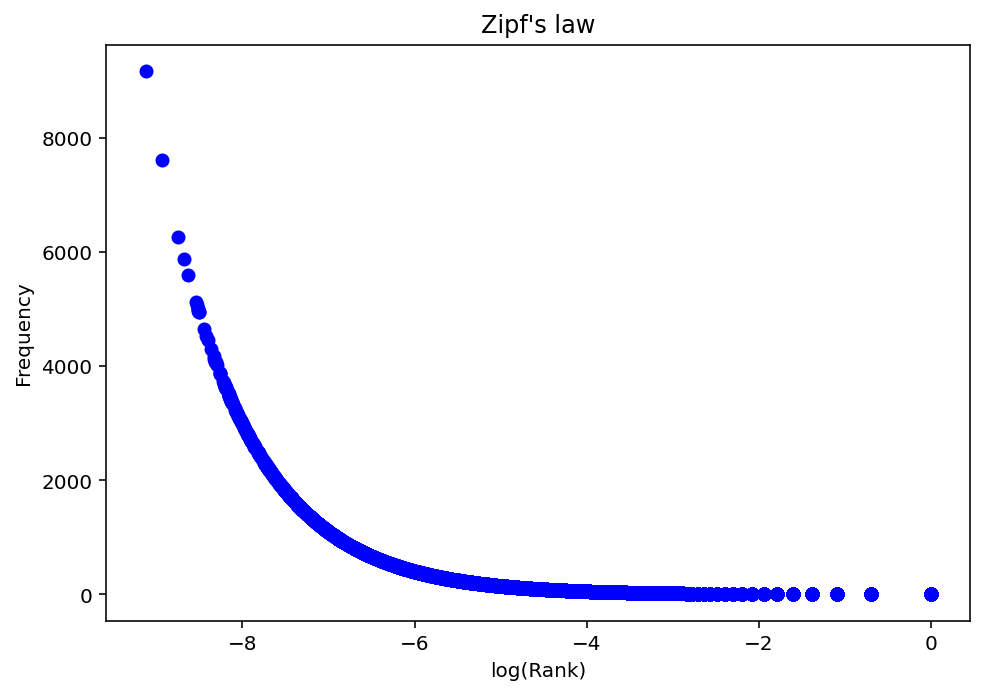

In [14]:
#Plot
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
plt.scatter(ranks, frequencies, color='blue')
ax.set_xlabel('log(Rank)')
ax.set_ylabel('Frequency')
ax.set_title('Zipf\'s law')
fig.savefig('Report/imgs/Zipf.eps', format='eps', bbox_inches='tight')
plt.show()

<h2>Get most significant words</h2>
<h3>Attempt #1: frequency density</h3>

In [15]:
#try to get the most frequent terms in a significant way

#Point density
frequency_list = frequencies[:]
frequency_list.sort()

#radius = 2
#precise but time expensive
def getFrequencyDensity(frequency_list, radius):
    frequency_density = []
    for i in range(len(frequency_list)):
        count = 0
        lim_inf = frequency_list[i] - radius
        lim_sup = frequency_list[i] + radius
        j = i
        while j >= 0 and frequency_list[j] >= lim_inf:
            count += 1
            j -= 1
        j = i
        while j < len(frequency_list) and frequency_list[j] <= lim_sup:
            count += 1
            j += 1
        frequency_density += [count/(2*radius)]
    return frequency_density

#frequency_density = getFrequencyDensity(frequency_list, radius)
"""
for word in inverted_index.keys():
    if len(inverted_index[word]) > 300:
        print(word)
"""

'\nfor word in inverted_index.keys():\n    if len(inverted_index[word]) > 300:\n        print(word)\n'

In [16]:
#Plot the frequency density 
"""
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.scatter(np.arange(len(frequency_density)), frequency_density, color='blue')
ax.set_xlabel('index')
ax.set_ylabel('Frequency density')
ax.set_title('Zipf\'s law')
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_axes([0,0,1,1])\nplt.scatter(np.arange(len(frequency_density)), frequency_density, color='blue')\nax.set_xlabel('index')\nax.set_ylabel('Frequency density')\nax.set_title('Zipf's law')\nplt.show()\n"

<h2>Get most significant words</h2>
<h3>Attempt #2: percentage</h3>

In [17]:
#get the most x% frequent terms
percentage = .00005

def getHighestValue(data, percentage):
    data_size = len(frequency_list)
    i = data_size * percentage
    return data[-round(i)]


#len(frequency_list)
def printMostFrequentTerms(inverted_index, frequency_list, percentage):
    for word in inverted_index.keys():
        if len(inverted_index[word]) > getHighestValue(frequency_list, percentage):
            print(word)

printMostFrequentTerms(inverted_index, frequency_list, percentage)

people
year
time
include
day


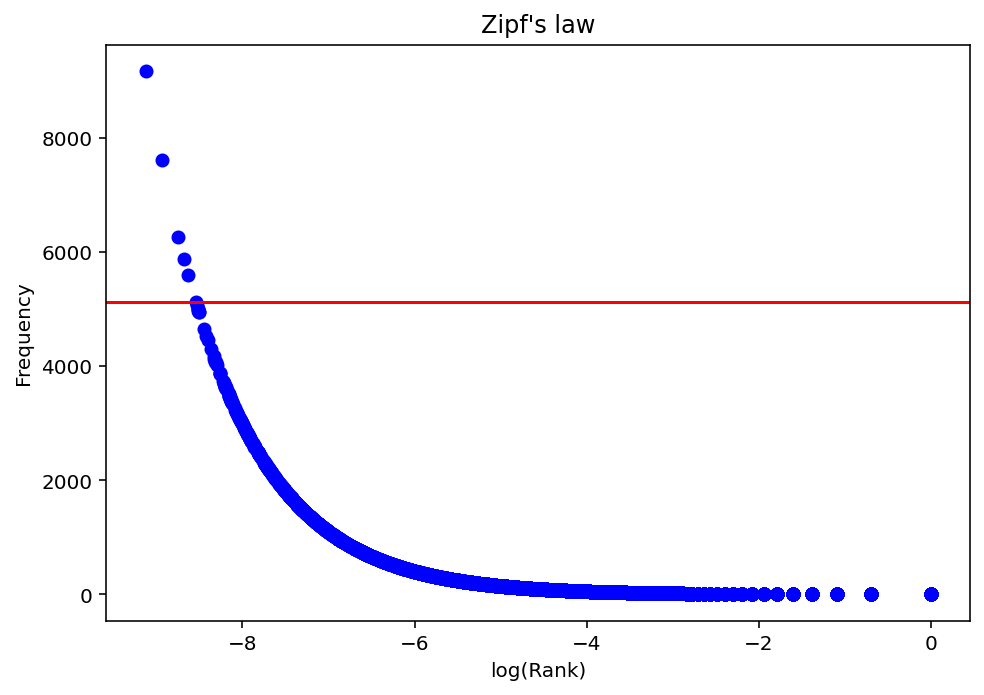

In [18]:
#plot the results
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
plt.scatter(ranks, frequencies, color='blue')
plt.axhline(y = getHighestValue(frequency_list, percentage), color = 'r', linestyle = '-')
ax.set_xlabel('log(Rank)')
ax.set_ylabel('Frequency')
ax.set_title('Zipf\'s law')
fig.savefig('Report/imgs/Zipf.eps', format='eps', bbox_inches='tight')
plt.show()

<h2>Term frequency: $tf$</h2>
<p>The occurencies of a term in a document divided by the total number of word in a document</p>
<p>Normalized term frequency for a term $j$ in a document $i$</p>
<h2>$tf_{ij} = \frac{f_{ij}}{M}$</h2>
<p>where $M$ is the number of different terms.</p>

In [19]:
#function
def getTermFrequency(document):
    #ProcessText is a function for tokenization
    doc = processText(readDocument(collection_path + '/' + document).text)
    num_terms = len(doc)
    tfIndex = {}
    for term in doc:
        tfIndex[term] = doc.count(term)/num_terms
    return tfIndex
#object
#XmlDoc(collection_path + '/' + doc_list[0]).getTF()

<h2>Inverse document frequency: $idf$</h2>
<p>for a term $j$</p>
<h2>$idf_{j} = log(\frac{N}{df_j})$</h2>
<p>where $N$ is the number of documents in the collection and $df_j$ is the number of documents that contain the term $j$.</p>

In [20]:
#Function
def getInverseDocumentFrequency(inverted_index, N):
    idf = {}
    for term in inverted_index.keys():
        idf[term] = np.log(N / len(inverted_index[term]))
    return idf
#getInverseDocumentFrequency(inverted_index, len(doc_list))

#Class
#document_collection.getIDF()

<h2>Balance exhaustivity $tf$ and specificity $idf$</h2>
<p>Any term in the collection can be attributed to a level of relevance calculated as</p>
<h2>$tf_{ij} \times idf_{j}$</h2>

In [21]:
document_collection.getRelevance(
    document_collection.docs[list(document_collection.docs.keys())[0]].id, 'buckle')

0

In [22]:
#is istance of str, else []
#lower
#expand contractions
#lemmatize
#remove punctuation
#remove stopwords
#remove single points
def getQueryVector(query):
    q = processText(query.title)
    qf = {}
    for term in q:
        if term not in qf:
            qf[term] = 1
        else:
            qf[term] += 1
    return qf


def getRelatedDocument(document_collection, query):
    s = set() #all document related with query
    query = getQueryVector(query)
    for term in query:
        if term in document_collection.inverted_index:
            s = s.union(set(document_collection.inverted_index[term]))
    return s, query


def getVectorSpace(document_collection, query):
    docs, query = getRelatedDocument(document_collection, query)
    space = {}
    for d in docs:
        space[d] = [document_collection.getRelevance(d, term) for term in query]
    return space

#getVectorSpace(document_collection, xmlq)
#document_collection.inverted_index['kiesbauer']

<h2>Vector space model VSM</h2>

In [57]:
class VectorSpaceModel:
    def __init__(self, document_collection, query_collection, 
                 fileName = 'vector-space-model.dictionary', track_id = '1', run_id='VSM'):
        self.document_collection = document_collection
        self.query_collection = query_collection
        self.unique_query_terms = set(query_collection.inverted_index.keys())
        self.track_id = track_id
        self.run_id = run_id
    
    def vectorizeXmlQuery(self, xmlQuery):
        return [self.query_collection.getRelevance(xmlQuery.id, t) for t in self.unique_query_terms]
        #return [self.query_collection.getRelevance(xmlQuery.id, t) for t in xmlQuery.processedText] #bad results
    
    def cosineSimilarity(self, vect1, vect2):
        norm1 = np.linalg.norm(vect1)
        norm2 = np.linalg.norm(vect2)
        dotP = np.dot(vect1, vect2)
        #origin vector is equal to itself
        if dotP == 0 and norm1 == 0 and norm2 == 0:
            return 1
        #origin vector is not equal to any vector but itself
        if norm1 == 0 or norm2 == 0:
            return 0
        return np.dot(vect1, vect2) / (norm1 * norm2)
    
    def computeSimilarity(self, query):
        v_query = self.vectorizeXmlQuery(query)
        simDict = {}
        documents_containing_query = set()
        for term in query.processedText:
            if term in self.document_collection.inverted_index:
                documents_containing_query = documents_containing_query.union(set(self.document_collection.inverted_index[term]))
                
        for id in documents_containing_query:
            v_space = [document_collection.getRelevance(id, t) for t in self.unique_query_terms]
            #v_space = [document_collection.getRelevance(id, t) for t in query.processedText] #bad results
            similarity = self.cosineSimilarity(v_space, v_query)
            if similarity not in simDict:
                simDict[similarity] = [id]
            else:
                simDict[similarity] += [id]
        return simDict
    
    def getRank(self, query):
        simDict = self.computeSimilarity(query)
        relevance = sorted(list(simDict.keys()), reverse=True )#list of relevance results
        return simDict, relevance
    
    
    def getQueryResult(self, query, topNumber=10):
        start = time.time()
        simDict, relevance = self.getRank(query)
        end = time.time()
        
        queryText = query.title
        
        print(str(topNumber) + ' top results for ' + queryText + ' (' + str(round(end-start, 4)) + 's)')
        res = ''
        for i in range(len(relevance[0:topNumber])):
            count = 0
            if relevance[i] != 0 and count < topNumber:
                for document in simDict[relevance[i]]:
                    res += query.id + ' ' + self.track_id + ' ' + document + ' ' + str(i) + ' ' + str(relevance[i]) + ' ' + self.run_id + self.track_id + '\n'
                    count += 1
        return res
        

In [59]:
vsm = VectorSpaceModel(document_collection, query_collection)
si = vsm.computeSimilarity(query_collection.queries['10.2452/188-AH'])


['german', 'spelling', 'reform'] {'LA122394-0061', 'LA012494-0093', 'LA093094-0183', 'LA071294-0263', 'LA022094-0107', 'LA080994-0214', 'LA061994-0304', 'LA071794-0116', 'LA120994-0255', 'LA071894-0157', 'LA051694-0189', 'LA012794-0255', 'LA020194-0007', 'LA042594-0058', 'LA071094-0284', 'LA030294-0030', 'LA112294-0147', 'LA020394-0022', 'LA021494-0182', 'LA052794-0163', 'LA021594-0194', 'LA092694-0171', 'LA012894-0061', 'LA060594-0005', 'LA030994-0297', 'LA121394-0165', 'LA061394-0176', 'LA030194-0143', 'LA110394-0344', 'LA061494-0148', 'LA031694-0234', 'LA091994-0117', 'LA021094-0078', 'LA121194-0367', 'LA092194-0211', 'LA091594-0016', 'LA040294-0245', 'LA103194-0116', 'LA120394-0066', 'LA090494-0042', 'LA041694-0078', 'LA111094-0006', 'LA042794-0182', 'LA032794-0136', 'LA061494-0033', 'LA032194-0149', 'LA050394-0066', 'LA041994-0138', 'LA061394-0168', 'LA041094-0046', 'LA071194-0052', 'LA012494-0025', 'LA102194-0238', 'LA121594-0296', 'LA012694-0072', 'LA061094-0309', 'LA111394-0304

In [52]:
#Init vector space model
vectorSpaceFile = 'vector-space-model.dictionary'
computeVSM = False or recomputeAll
if computeVSM or not os.path.isfile(vectorSpaceFile):
    start = time.time()
    vsm = VectorSpaceModel(document_collection, query_collection, vectorSpaceFile)
    end = time.time()
    print('Vector Space Model Computed in ' + str(round(end - start, 4)) + 's')
else:
    start = time.time()
    with open(vectorSpaceFile, 'rb') as dictionary_file:
        vsm = pickle.load(dictionary_file) 
    end = time.time()
    print('Vector Space Model Loaded in ' + str(round(end - start, 4)) + 's')

Vector Space Model Computed in 0.0s


<h2>Generate the VSM report for trec_eval</h2>

In [53]:
#vsm.track_id = '0'
#vsm.track_id = '1'
vsm.track_id = '2'

#print(vsm.getQueryResult(query_collection.queries['10.2452/141-AH']))
out_path = 'IR_output/'
useLemma = '_Lemma' if use_lemmatization else '_NoLemma'
generateVSMReport = True
# generate output file for VSM
if generateVSMReport:
    vsmFile = open(out_path + 'VSM/' + vsm.run_id + vsm.track_id + useLemma + "Y.out", "w")
    start = time.time()
    for q in query_collection.queries.keys():
        vsmFile.write(vsm.getQueryResult(query_collection.queries[q]))
    vsmFile.close()
    end = time.time()
    print('VSM Results obtained in ' + str(round(end-start, 4)) + 's')

10 top results for  Dutch Photos of Srebrenica (0.1915s)
10 top results for  German Spelling Reform (0.5458s)
10 top results for  Nestlé Brands (0.0313s)
10 top results for  Human Cloning and Ethics (0.4702s)
10 top results for  Yann Piat ' s Assassination (0.0847s)
10 top results for  Children ' s Rights (1.025s)
10 top results for  Oil Prices (0.5832s)
10 top results for  Shoemaker-Levy and Jupiter (0.016s)
10 top results for  Shooting of Tupac Shakur (0.2121s)
10 top results for  Risks with Mobile Phones (0.2761s)
10 top results for  Treaty Ratification (0.1242s)
10 top results for  Oil Price Fluctuation (0.6397s)
10 top results for  Prison Abuse (0.3386s)
10 top results for  Scotch Production Consumption (0.3717s)
10 top results for  Earthquakes in Mexico_City (0.1581s)
10 top results for  Discrimination against European Gypsies (0.4966s)
10 top results for  Nuclear Power_Stations (0.1716s)
10 top results for  Czech President ' s Background (1.5176s)
10 top results for  EU Agricult

10 top results for  Sex Education (0.5373s)
10 top results for  Trial of Paul Touvier (0.5776s)
10 top results for  Microsoft Competitors (0.12s)
10 top results for  Atomic Energy (0.288s)
10 top results for  Emmy International Awards (1.054s)
10 top results for  Football Refereeing Disputes (0.252s)
10 top results for  Consequences if Charles and Diana Divorce (0.4564s)
10 top results for  Military_Service Denial (0.0469s)
VSM Results obtained in 59.9748s


<h2>BM25 ranking</h2>
<p>For a query $Q$, containing terms $q_1 \dots, q_n$, the <b>BM25</b> score for a document $D$ is: </p>
<h1>$Relevance(D,Q) = \sum_{i=1}^{n}IDF(q_i) \cdot \frac{tf(D, q_i) \cdot (k + 1)}{tf(D, q_i) + k \cdot (1 - b - \frac{b|D|}{avgdl})} $</h1><

In [63]:
#document_collection.avgdl = np.mean([len(item.processedText) for k, item in document_collection.docs.items()])
class BM25Result:
    def __init__(self, q_id, d_id, relevance):
        self.q_id = q_id
        self.d_id = d_id
        self.relevance = relevance
        
        
class BM25:
    def __init__(self, 
                 document_collection, 
                 query_collection, 
                 k = 1.2, 
                 b = .75,
                 track_id = 'k1.2-b0.75', 
                 run_id='BM25'                 
                ):
        self.document_collection = document_collection
        self.query_collection = query_collection
        self.k = k
        self.b = b
        self.track_id = 'k'+str(k)+'-'+'b'+str(b)
        self.run_id = run_id
        
    def calculateRelevance(self, document, query):
        #unique_query_terms = set(query_collection.inverted_index.keys())
        rel = 0
        for q_i in query.processedText:
            idfq_i = self.query_collection.idf[q_i]
            try:
                tf_d_q_i = document.tfIndex[q_i] 
            except:
                tf_d_q_i = 0
            avgdl = self.document_collection.avgdl
            num = tf_d_q_i * (self.k + 1)
            den = tf_d_q_i + self.k * (1 - self.b - self.b * len(document.processedText) / avgdl)
            rel += idfq_i * num / den
        return rel
    
    def getQueryResult(self, query, limitResult = 10):
        rank = []
        start = time.time()
        documents_containing_query = set()
        for term in query.processedText:
            if term in self.document_collection.inverted_index:
                documents_containing_query = documents_containing_query.union(set(self.document_collection.inverted_index[term]))
        for doc_id in documents_containing_query:
            rank += [BM25Result(query.id, doc_id, self.calculateRelevance(self.document_collection.docs[doc_id], query))] 
        rank.sort(key=lambda x: x.relevance, reverse=True)
        res = ''
        for i in range(len(rank[0:limitResult])):
            if rank[i].relevance != 0:
                res += rank[i].q_id + ' ' + self.track_id + ' ' + rank[i].d_id + ' ' + str(i) + ' ' + str(rank[i].relevance) + ' ' + self.run_id + self.track_id + '\n'
        end = time.time()
        print('Query: ' + query.id + ' ranked in ' + str(end-start) + 's')
        return res
    
    def getReport(self, out_folder = 'BM25/'):
        bm25File = open(out_path + out_folder + self.run_id + self.track_id + useLemma + ".out", "w")
        for q in self.query_collection.queries.keys():
            bm25File.write(self.getQueryResult(self.query_collection.queries[q]))
        bm25File.close()
            
bm25 = BM25(document_collection, query_collection)
#bm25.calculateRelevance(document_collection.docs['LA080294-0033'], query_collection.queries['10.2452/185-AH'])
start = time.time()
bm25.getReport()
end = time.time()
print('BM25 Results obtained in ' + str(round(end-start, 4)) + 's')

Query: 10.2452/185-AH ranked in 1.1435348987579346s
Query: 10.2452/188-AH ranked in 1.2663884162902832s
Query: 10.2452/301-AH ranked in 0.2200465202331543s
Query: 10.2452/268-AH ranked in 3.1002132892608643s
Query: 10.2452/348-AH ranked in 0.4001336097717285s
Query: 10.2452/152-AH ranked in 4.785839080810547s
Query: 10.2452/305-AH ranked in 36.17536401748657s
Query: 10.2452/176-AH ranked in 0.030628681182861328s
Query: 10.2452/332-AH ranked in 0.25592732429504395s
Query: 10.2452/155-AH ranked in 0.3404994010925293s
Query: 10.2452/269-AH ranked in 0.0878758430480957s
Query: 10.2452/290-AH ranked in 0.3174021244049072s
Query: 10.2452/282-AH ranked in 0.23649930953979492s
Query: 10.2452/160-AH ranked in 0.23508214950561523s
Query: 10.2452/327-AH ranked in 0.05503392219543457s
Query: 10.2452/266-AH ranked in 0.16976547241210938s
Query: 10.2452/298-AH ranked in 0.03401350975036621s
Query: 10.2452/272-AH ranked in 0.5196971893310547s
Query: 10.2452/276-AH ranked in 0.01900315284729004s
Query

<h2>BM25F </h2>

In [29]:
class BM25F:
    def __init__(self, 
                 document_collection, 
                 query_collection, 
                 k = 1.2, 
                 b = .75,
                 track_id = 'k1.2-b0.75', 
                 run_id='BM25F'                 
                ):
        self.document_collection = document_collection
        self.query_collection = query_collection
        self.k = k
        self.b = b
        self.track_id = 'k'+str(k)+'-'+'b'+str(b)
        self.run_id = run_id
        
    def getQueryResult(self, query, limitResult = 10):
        rank = []
        start = time.time()
        documents_containing_query = set()
        for term in query.processedText:
            if term in self.document_collection.inverted_index:
                documents_containing_query = documents_containing_query.union(set(self.document_collection.inverted_index[term]))
        for doc_id in documents_containing_query:
            rank += [BM25Result(query.id, doc_id, self.calculateRelevance(self.document_collection.docs[doc_id], query))] 
        rank.sort(key=lambda x: x.relevance, reverse=True)
        res = ''
        for i in range(len(rank[0:limitResult])):
            if rank[i].relevance != 0:
                res += rank[i].q_id + ' ' + self.track_id + ' ' + rank[i].d_id + ' ' + str(i) + ' ' + str(rank[i].relevance) + ' ' + self.run_id + self.track_id + '\n'
        end = time.time()
        print('Query: ' + query.id + ' ranked in ' + str(end-start) + 's')
        return res
        
    def calculateRelevance(self, document, query):
        #unique_query_terms = set(query_collection.inverted_index.keys())
        rel = 0
        for q_i in query.processedText:
            idfq_i = self.query_collection.idf[q_i]
            try:
                tf_d_q_i = self.document_collection.getWeightedTf(document.id, q_i, w_head=7, w_body=3)
            except:
                tf_d_q_i = 0
            avgdl = self.document_collection.avgdl
            num = tf_d_q_i * (self.k + 1)
            den = tf_d_q_i + self.k * (1 - self.b - self.b * len(document.processedText) / avgdl)
            rel += idfq_i * num / den
        return rel
        
    def getReport(self, out_folder = 'BM25F/'):
        bm25File = open(out_path + out_folder + self.run_id + self.track_id + useLemma + ".out", "w")
        for q in self.query_collection.queries.keys():
            bm25File.write(self.getQueryResult(self.query_collection.queries[q]))
        bm25File.close()
        
        
bm25f = BM25F(document_collection, query_collection)
#bm25.calculateRelevance(document_collection.docs['LA080294-0033'], query_collection.queries['10.2452/185-AH'])
start = time.time()
bm25f.getReport()
end = time.time()
print('BM25F Results obtained in ' + str(round(end-start, 4)) + 's')

Query: 10.2452/185-AH ranked in 0.013962507247924805s
Query: 10.2452/188-AH ranked in 0.048866987228393555s
Query: 10.2452/301-AH ranked in 0.007726192474365234s
Query: 10.2452/268-AH ranked in 0.04059243202209473s
Query: 10.2452/348-AH ranked in 0.004985809326171875s
Query: 10.2452/152-AH ranked in 0.03094792366027832s
Query: 10.2452/305-AH ranked in 0.044844627380371094s
Query: 10.2452/176-AH ranked in 0.002991914749145508s
Query: 10.2452/332-AH ranked in 0.006973743438720703s
Query: 10.2452/155-AH ranked in 0.053528547286987305s
Query: 10.2452/269-AH ranked in 0.005997896194458008s
Query: 10.2452/290-AH ranked in 0.06539607048034668s
Query: 10.2452/282-AH ranked in 0.02194976806640625s
Query: 10.2452/160-AH ranked in 0.02691173553466797s
Query: 10.2452/327-AH ranked in 0.01595306396484375s
Query: 10.2452/266-AH ranked in 0.03390860557556152s
Query: 10.2452/298-AH ranked in 0.007892370223999023s
Query: 10.2452/272-AH ranked in 0.1147298812866211s
Query: 10.2452/276-AH ranked in 0.006

Query: 10.2452/263-AH ranked in 0.02293872833251953s
Query: 10.2452/329-AH ranked in 0.032065629959106445s
Query: 10.2452/178-AH ranked in 0.0034706592559814453s
BM25F Results obtained in 6.5271s
